In [9]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import os
from huggingface_hub import login
import pickle
import einops
import random
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 8,        # Overall figure title size
})

# Load Model

In [2]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers
NHEADS = model.config.n_head

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

# Get normal and intervention dataframes

In [3]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = 0, maxa = 99, num_sample = 500, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}.pkl')
    
#get_df_sample(run = False)

In [4]:
def gen_intervention(mina, maxa, samplesize = 1000, run = False):
    if run:
        df = get_df_sample(mina, maxa, run = False)
        # Create cartesian product of df with itself
        intervention_df = df.merge(df, how='cross', suffixes=('_original', '_intervened'))
        # Filter out cases where original answer equals intervened answer
        intervention_df = intervention_df[intervention_df['answer_original'] != intervention_df['answer_intervened']]
        # Take random sample of size samplesize
        if samplesize < len(intervention_df):
            intervention_df = intervention_df.sample(n=samplesize, random_state=42).reset_index(drop = True)
        # Save to pickle file
        intervention_df.to_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    intervention_df = pd.read_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    return intervention_df

#gen_intervention(0,99)

# Act and Path Patch MLP and Attention Layers

In [5]:
def calc_log_diff(original_logits, patched_logits, patched_answer_tokens):
    return patched_logits[range(len(patched_logits)), patched_answer_tokens] - original_logits[range(len(original_logits)), patched_answer_tokens]

def attn_mlp_activation_patch(mina, maxa):
    df = gen_intervention(mina, maxa)
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    results = {'layers':[], 'mlp_logdiff':[], 'attn_logdiff':[]}
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        #original_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_original'].values]).to(device)
        patched_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_intervened'].values]).to(device)
        patched_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        bar = tqdm(range(NLAYERS))
        for layer in bar:
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens, scan=False):
                    pass
                with tracer.invoke(patched_tokens, scan=False):
                    attn = model.transformer.h[layer].attn.out_proj.input[:,-1].save()
                    mlp = model.transformer.h[layer].mlp.output[:,-1].save()
                with tracer.invoke(original_tokens, scan = False):
                    model.transformer.h[layer].attn.out_proj.input[:,-1] = attn
                with tracer.invoke(original_tokens, scan = False):
                    model.transformer.h[layer].mlp.output[:,-1] = mlp
                logits = model.output.logits.save()
            logits = logits[:,-1]
            batch_size = logits.shape[0] // 4
            original_logits = logits[:batch_size]
            attn_logits = logits[2*batch_size:3*batch_size]
            mlp_logits = logits[3*batch_size:4*batch_size]
            mlp_logdiff = calc_log_diff(original_logits, mlp_logits, patched_answers).mean().item()
            attn_logdiff = calc_log_diff(original_logits, attn_logits, patched_answers).mean().item()
            results['layers'].append(layer)
            results['attn_logdiff'].append(attn_logdiff)
            results['mlp_logdiff'].append(mlp_logdiff)
            bar.set_postfix({k:results[k][-1] for k in results.keys()})
    # Convert results to dataframe and save
    results_df = pd.DataFrame(results)
    results_df.to_pickle(f'data_addition/ab_patching/attn_mlp_activation_patching_{mina}_{maxa}.pkl')
    return results_df

#attn_mlp_activation_patch(0,99)


In [16]:
def attn_mlp_path_patch(mina, maxa):
    df = gen_intervention(mina, maxa)
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    results = {'layers':[], 'mlp_logdiff':[], 'attn_logdiff':[]}
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        #original_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_original'].values]).to(device)
        patched_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_intervened'].values]).to(device)
        patched_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        bar = tqdm(range(NLAYERS))
        for layer in [1]:#bar:
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens, scan=False):
                    attn_original = model.transformer.h[layer].attn.output[0][:,-1].save()
                    mlp_original = model.transformer.h[layer].mlp.output[:,-1].save()
                with tracer.invoke(patched_tokens, scan=False):
                    attn_patched = model.transformer.h[layer].attn.output[0][:,-1].save()
                    mlp_patched = model.transformer.h[layer].mlp.output[:,-1].save()
                with tracer.invoke(original_tokens, scan = False):
                    model.transformer.h[-1].output[0][:,-1] += attn_patched - attn_original
                with tracer.invoke(original_tokens, scan = False):
                    model.transformer.h[-1].output[0][:,-1] += mlp_patched - mlp_original
                logits = model.output.logits.save()
            logits = logits[:,-1]
            batch_size = logits.shape[0] // 4
            original_logits = logits[:batch_size]
            attn_logits = logits[2*batch_size:3*batch_size]
            mlp_logits = logits[3*batch_size:4*batch_size]
            mlp_logdiff = calc_log_diff(original_logits, mlp_logits, patched_answers).mean().item()
            attn_logdiff = calc_log_diff(original_logits, attn_logits, patched_answers).mean().item()
            results['layers'].append(layer)
            results['attn_logdiff'].append(attn_logdiff)
            results['mlp_logdiff'].append(mlp_logdiff)
            bar.set_postfix({k:results[k][-1] for k in results.keys()})
    # Convert results to dataframe and save
    results_df = pd.DataFrame(results)
    #results_df.to_pickle(f'data_addition/ab_patching/attn_mlp_path_patching_{mina}_{maxa}.pkl')
    return results_df

attn_mlp_path_patch(0,99)


  0%|          | 0/28 [00:01<?, ?it/s, layers=1, mlp_logdiff=0.00141, attn_logdiff=-0.000547]


,layers,mlp_logdiff,attn_logdiff
0,1,0.001406,-0.000547


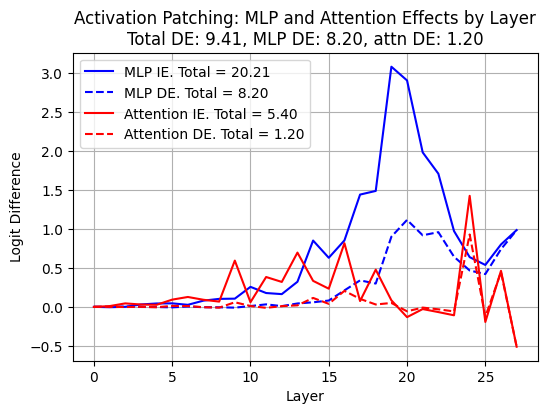

In [4]:
def plot_act_patch():
    # Load results from pickle files
    results_df_act = pd.read_pickle(f'data_addition/ab_patching/attn_mlp_activation_patching_0_99.pkl')
    results_df_path = pd.read_pickle('data_addition/ab_patching/attn_mlp_path_patching_0_99.pkl')
    mlp_de, mlp_ie = results_df_path['mlp_logdiff'].sum(), results_df_act['mlp_logdiff'].sum()
    attn_de, attn_ie = results_df_path['attn_logdiff'].sum(), results_df_act['attn_logdiff'].sum()
    # Create the plot
    plt.figure(figsize=(6,4))
    plt.plot(results_df_act['layers'], results_df_act['mlp_logdiff'], color='blue', label=f'MLP IE. Total = {mlp_ie:.2f}')
    plt.plot(results_df_path['layers'], results_df_path['mlp_logdiff'], color='blue', label=f'MLP DE. Total = {mlp_de:.2f}', linestyle = '--')
    plt.plot(results_df_act['layers'], results_df_act['attn_logdiff'], color='red', label=f'Attention IE. Total = {attn_ie:.2f}')
    plt.plot(results_df_path['layers'], results_df_path['attn_logdiff'], color='red', label=f'Attention DE. Total = {attn_de:.2f}', linestyle = '--')
    # print(results_df_path['mlp_logdiff'].values)
    # print(results_df_act['mlp_logdiff'].values)
    plt.title(f'Activation Patching: MLP and Attention Effects by Layer\nTotal DE: {mlp_de+attn_de:.2f}, MLP DE: {mlp_de:.2f}, attn DE: {attn_de:.2f}')
    plt.xlabel('Layer')
    plt.ylabel('Logit Difference')
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    plt.savefig('figs_addition/ab_patching/act_path_patching_mlp_attn.png')
    plt.show()
    plt.close()
    

plot_act_patch() 

# Act Patch Attention Heads

In [8]:
def attn_head_act_patch(mina, maxa):
    df = gen_intervention(mina, maxa)
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    batch_size = len(df_subset)
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_intervened'].values]).to(device)
        corrupted_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        z_hs = {}
        attn_originals = []
        with model.trace(validate=False, remote=remote) as tracer:
            # STEP 1: Clean run, grab clean activations for each attention head
            with tracer.invoke(corrupted_tokens) as invoker:
                for layer_idx in range(NLAYERS):
                    # attention output for llama models needs to be reshaped to look at individual heads
                    z = model.transformer.h[layer_idx].attn.out_proj.input # dimensions [1x15x4096] [batch x seq x D_MODEL]
                    z_reshaped = einops.rearrange(z, 'b s (nh dh) -> b s nh dh',nh=NHEADS)
                    for head_idx in range(NHEADS):
                        z_hs[layer_idx,head_idx] = z_reshaped[:,:,head_idx,:].save()
            # STEP 2: Corrupted run, grab corrupted logits for later comparison.
            with tracer.invoke(original_tokens) as invoker:
                for layer_idx in range(NLAYERS):
                    attn_original = model.transformer.h[layer_idx].attn.output[0][:,-1].save()
                    attn_originals.append(attn_original)
                logits = model.output.logits[:,-1].save()
            # Patching: Iterate through all the layers
        original_logits = logits[batch_size:]
        logdiffs = {}
        bar = tqdm([(l,h) for l in range(NLAYERS) for h in range(NHEADS)], desc="Patching heads")
        #bar = tqdm([(l,h) for l in [24] for h in range(NHEADS)], desc="Patching heads")
        for layer_idx, head_idx in bar:
            with model.trace(validate=False, remote=remote) as tracer:
                # Patching corrupted run at given layer and token
                with tracer.invoke(original_tokens) as invoker:
                    #Apply the patch from the clean hidden states to the corrupted hidden state for given layer and head.
                    z_original = model.transformer.h[layer_idx].attn.out_proj.input 
                    z_original = einops.rearrange(z_original, 'b s (nh dh) -> b s nh dh',nh=NHEADS)
                    z_original[:,-1,head_idx,:] = z_hs[layer_idx,head_idx][:,-1] # ONLY DO EXCHANGE AT LAST SEQPOS
                    z_original = einops.rearrange(z_original, 'b s nh dh -> b s (nh dh)', nh=NHEADS)
                    model.transformer.h[layer_idx].attn.out_proj.input  = z_original
                    attn_patched = model.transformer.h[layer_idx].attn.output[0][:,-1].save()
                with tracer.invoke(original_tokens) as invoker:
                    model.transformer.h[-1].output[0][:,-1] += attn_patched - attn_originals[layer_idx]
                    patchedlogits = model.output.logits[:,-1].save()
            diff = attn_patched - attn_originals[layer_idx]
            act_patched_logits = patchedlogits[:batch_size]
            path_patched_logits = patchedlogits[batch_size:]
            ie_logdiff = calc_log_diff(original_logits, act_patched_logits, corrupted_answers).mean().item()
            de_logdiff = calc_log_diff(original_logits, path_patched_logits, corrupted_answers).mean().item()
            logdiffs[(layer_idx, head_idx)] = (ie_logdiff, de_logdiff)
            bar.set_postfix({'l':layer_idx, 'head':head_idx, 'ie_logdiff': ie_logdiff, 'de_logdiff':de_logdiff})
    with open(f'data_addition/ab_patching/attn_head_activation_patching_{mina}_{maxa}.pkl', 'wb') as f:
        pickle.dump(logdiffs, f)
    return logdiffs
#logdiffs = attn_head_act_patch(0,99)

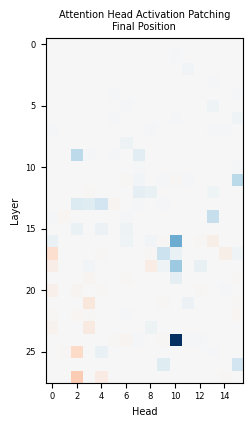

In [39]:
def get_patching_results(patch_type = 'activation'):
    # Convert dictionary to 2D array
    logdiffs = pd.read_pickle(f'data_addition/ab_patching/attn_head_activation_patching_0_99.pkl')
    attn_matrix = np.zeros((NLAYERS, NHEADS))
    for (layer, head), value in logdiffs.items():
        # Use first value for activation patching, second for path patching
        attn_matrix[layer, head] = value[0] if patch_type == 'activation' else value[1]
    return attn_matrix

def plot_attn_head_act_patch(plot_type='activation'):
    # Load results from pickle files
    

    attn_matrix = get_patching_results(plot_type)
    # Get max absolute value for symmetric colorbar
    vmax = max(abs(attn_matrix.min()), abs(attn_matrix.max()))
    
    # Create matplotlib figure and set size before any plotting
    plt.figure(figsize=(3.25,4.25))
    plt.clf() # Clear any existing plots
    
    # Create the heatmap
    plt.imshow(attn_matrix, cmap='RdBu', vmin=-vmax, vmax=vmax)
    #plt.colorbar(label='Attention Log Diff')
    
    # Add labels and title
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.title(f'Attention Head {plot_type.capitalize()} Patching\nFinal Position')
    
    # Set x-ticks at every other 2 integers
    plt.xticks(range(0, NHEADS, 2))
    
    # Find top 30 heads
    flat_indices = np.argsort(attn_matrix.ravel())[-20:]
    top_layers, top_heads = np.unravel_index(flat_indices, attn_matrix.shape)
    
    # Add annotations for top 30 heads
    max_value = attn_matrix.ravel()[flat_indices[-1]]  # Get the maximum value
    # for l, h, idx in zip(top_layers, top_heads, flat_indices):
    #     value = attn_matrix.ravel()[idx]
    #     color = 'black' if value < 0.25 * max_value else 'white'
    #     plt.text(h, l, f'{value:.2f}', ha='center', va='center', color=color, fontsize=4.5)
    
    # Save the plot
    plt.tight_layout()
    plt.savefig(f'figs_addition/ab_patching/attention_head_{plot_type}_patching.png', dpi=300, bbox_inches='tight')
    
    # Show and close in separate steps
    plt.show()
    plt.close('all') # Close all figures to free memory

plot_attn_head_act_patch('activation')

# Circuit study
patch in topk heads, do nothing for rest

In [16]:
def get_topk_attn_heads(k = 4):
    logdiffs = pd.read_pickle(f'data_addition/ab_patching/attn_head_activation_patching_0_99.pkl')
    # Sort logdiffs by value in descending order and get top k heads
    sorted_items = sorted(logdiffs.items(), key=lambda x: x[1], reverse=True)
    sorted_heads = [head for head, _ in sorted_items]
    sorted_values = [val for _, val in sorted_items] 
    return sorted_heads[:k], sorted_values[:k]

#get_topk_attn_heads(12)

In [17]:
def topk_heads_act_patch(k, mina, maxa):
    heads = get_topk_attn_heads(k)
    df = gen_intervention(mina, maxa)
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    batch_size = len(df_subset)
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_intervened'].values]).to(device)
        corrupted_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        z_hs = {}
        with model.trace(validate=False, remote=remote) as tracer:
            # STEP 1: Clean run, grab clean activations for each attention head
            with tracer.invoke(corrupted_tokens) as invoker:
                for layer_idx in range(NLAYERS):
                    # attention output for llama models needs to be reshaped to look at individual heads
                    z = model.transformer.h[layer_idx].attn.out_proj.input # dimensions [1x15x4096] [batch x seq x D_MODEL]
                    z_reshaped = einops.rearrange(z, 'b s (nh dh) -> b s nh dh',nh=NHEADS)
                    for head_idx in range(NHEADS):
                        z_hs[layer_idx,head_idx] = z_reshaped[:,:,head_idx,:].save()
            # STEP 2: Corrupted run, grab corrupted logits for later comparison.
            with tracer.invoke(original_tokens) as invoker:
                logits = model.output.logits[:,-1].save()
            # Patching: Iterate through all the layers
        original_logits = logits[batch_size:]
        with model.trace(validate=False, remote=remote) as tracer:
            # Patching corrupted run at given layer and token
            with tracer.invoke(original_tokens) as invoker:
                for layer_idx, head_idx in heads:
                    # Apply the patch from the clean hidden states to the corrupted hidden state for given layer and head.
                    z_original = model.transformer.h[layer_idx].attn.out_proj.input 
                    z_original = einops.rearrange(z_original, 'b s (nh dh) -> b s nh dh',nh=NHEADS)
                    z_original[:,-1,head_idx,:] = z_hs[layer_idx,head_idx][:,-1] # ONLY DO EXCHANGE AT LAST SEQPOS
                    z_original = einops.rearrange(z_original, 'b s nh dh -> b s (nh dh)', nh=NHEADS)
                    model.transformer.h[layer_idx].attn.out_proj.input  = z_original
                patched_logits = model.output.logits[:,-1].save()
        logdiff = calc_log_diff(original_logits, patched_logits, corrupted_answers).mean().item()
    return logdiff
#topk_heads_act_patch(447, 0,99)


Log difference at k=20: 0.838781


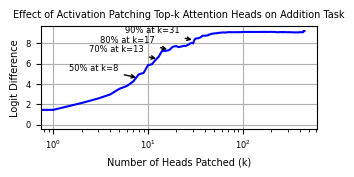

In [34]:
def run_topk_patches(mina, maxa):
    results = {'k':[], 'logdiff':[]}
    bar = tqdm(range(NLAYERS*NHEADS+1))
    for k in bar:
        ldiff = topk_heads_act_patch(k, mina, maxa)
        results['k'].append(k)
        results['logdiff'].append(ldiff)
        bar.set_postfix({k:results[k][-1] for k in results.keys()})
        # Save results after each k to track progress
    with open(f'data_addition/ab_patching/topk_activation_patching_results_{mina}_{maxa}.pkl', 'wb') as f:
        pickle.dump(results, f)
def plot_topk_patches(mina, maxa):
    with open(f'data_addition/ab_patching/topk_activation_patching_results_{mina}_{maxa}.pkl', 'rb') as f:
        results = pickle.load(f)
    
    k_vals = results['k']
    logdiffs = results['logdiff']
    max_logdiff = max(logdiffs)
    # Print result at k=20
    k20_idx = k_vals.index(20)
    print(f"Log difference at k=20: {logdiffs[k20_idx]/max_logdiff:.6f}")
    
    thresholds = [0.5, 0.7, 0.8, 0.9]
    min_k_vals = []
    for threshold in thresholds:
        target = threshold * max_logdiff
        for k, ld in zip(k_vals, logdiffs):
            if ld >= target:
                min_k_vals.append(k)
                break
                
    plt.figure(figsize=(3.25,1.75))
    plt.semilogx(k_vals, logdiffs, color = 'b')
    plt.grid(True)
    plt.xlabel('Number of Heads Patched (k)')
    plt.ylabel('Logit Difference')
    
    for threshold, min_k in zip(thresholds, min_k_vals):
        plt.annotate(f'{int(threshold*100)}% at k={min_k}', 
                    xy=(min_k,max_logdiff*threshold),
                    xytext=(-50, 5), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->'))
    plt.title('Effect of Activation Patching Top-k Attention Heads on Addition Task')
    plt.tight_layout()
    plt.savefig('figs_addition/ab_patching/topk_activation_patching.png', bbox_inches='tight', dpi=300)
#run_topk_patches(0,99)

plot_topk_patches(0,99)

# Visualize Topk Attention Patterns

In [13]:
def get_attn_pattern(layer, head, mina = 0, maxa = 99):
    df = get_correct_df(mina, maxa)
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok'].values]).to(device)
    attn_patterns = []
    with model.trace(validate=False, remote=remote) as tracer:
        # STEP 1: Clean run, grab clean activations for each attention head
        with tracer.invoke(tokens) as invoker:
            for layer in range(NLAYERS):
                attn_pattern = model.transformer.h[layer].attn.attn_dropout.input.save()
                attn_patterns.append(attn_pattern)
    at = torch.stack(attn_patterns)
    # Save attention patterns tensor
    save_path = 'data_addition/ab_patching/attention_patterns.pt'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(at, save_path)
    return at
#get_attn_pattern(18,10)

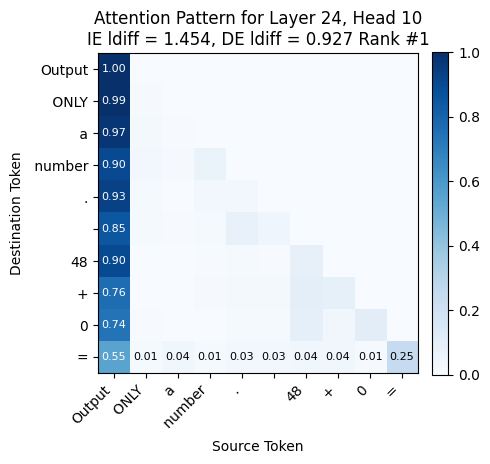

In [14]:
import random
def plot_topk_attention_patterns(k = 20):
    heads, _ = get_topk_attn_heads(k)
    for layer, head in tqdm(heads):
        plot_attention_pattern(layer, head, show = False)

def plot_attention_pattern(layer, head, show = True):
    logdiffs = pd.read_pickle(f'data_addition/ab_patching/attn_head_activation_patching_0_99.pkl')
    logitdiff = logdiffs[(layer,head)]
    # Convert logdiffs dict to sorted list of (head, logdiff) pairs
    sorted_heads = sorted(logdiffs.items(), key=lambda x: x[1], reverse=True)
    # Find rank of current head
    rank = next(i for i, (h, _) in enumerate(sorted_heads) if h == (layer, head)) + 1
    #print(f"Head ({layer},{head}) has logitdiff {logitdiff:.3f} (rank {rank} out of {len(sorted_heads)})")
    df = get_correct_df(0, 99)
    ex_tokens = df['q_tok'].values[random.randint(0, len(df)-1)]
    ex_tokens = model.tokenizer.batch_decode(ex_tokens)
    at = torch.load('data_addition/ab_patching/attention_patterns.pt', weights_only = False).detach().cpu().float()
    at = at[layer,:,head].mean(dim = 0)
    
    plt.figure(figsize=(5,5))
    plt.imshow(at.cpu(), cmap='Blues')
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.xticks(range(len(ex_tokens)), ex_tokens, rotation=45, ha='right')
    plt.yticks(range(len(ex_tokens)), ex_tokens)
    
    # Annotate all values in last row
    for i in range(at.shape[0]):
        for j in range(at.shape[1]):
            if i == at.shape[0]-1 or at[i,j] > 0.2:  # Annotate last row or values > 0.2
                plt.text(j, i, f'{at[i,j]:.2f}',
                        ha='center', va='center', fontsize = 8, 
                        color='white' if at[i,j] > 0.5 else 'black')
    plt.ylabel('Destination Token')
    plt.xlabel('Source Token')
    ie, de = logitdiff
    plt.title(f'Attention Pattern for Layer {layer}, Head {head}\nIE ldiff = {ie:.3f}, DE ldiff = {de:.3f} Rank #{rank}')
    plt.tight_layout()
    plt.savefig(f'figs_addition/ab_attn_heads/topk_head_attentionpatterns/{rank}. L{layer}H{head}.png')
    if show:
        plt.show()
    plt.close()
plot_attention_pattern(24, 10)
#plot_topk_attention_patterns(448)

In [15]:
def get_last_token_attn(heads):
    ats = torch.load('data_addition/ab_patching/attention_patterns.pt', weights_only = False).detach().cpu().float()
    last_tok = []
    for layer, head in heads:
        at = ats[layer,:,head].mean(dim = 0)
        last_tok.append(at[-1])
    last_tok = torch.stack(last_tok)
    return last_tok

def plot_topk_attn_lasttoken(k = 20):
    df = get_correct_df(0, 99)
    ex_tokens = df['q_tok'].values[random.randint(0, len(df)-1)]
    ex_tokens = model.tokenizer.batch_decode(ex_tokens)
    heads, logdiffs = get_topk_attn_heads(k)
    last_tok = get_last_token_attn(heads)
    plt.figure(figsize=(10,8))
    plt.imshow(last_tok, cmap='Blues')
    plt.colorbar(fraction=0.046, pad=0.04)
    
    # Label y-axis with head info
    head_labels = [f"{l}.{h}: {ie:.3f}" for (l,h), (ie,de) in zip(heads, logdiffs)]
    plt.yticks(range(len(heads)), head_labels)
    
    # Label x-axis with tokens
    plt.xticks(range(len(ex_tokens)), ex_tokens, rotation=45, ha='right')
    
    # Annotate values > 0.2
    for i in range(last_tok.shape[0]):
        row = last_tok[i]
        for j in range(row.shape[0]):
            if row[j] > 0.2:
                plt.text(j, i, f'{row[j]:.2f}',
                        ha='center', va='center', fontsize=8,
                        color='white' if row[j] > 0.5 else 'black')
    
    plt.title('Top-k Heads Attention Patterns at Last Token')
    plt.tight_layout()

#plot_topk_attn_lasttoken()

# Figuring out DE vs IE heads

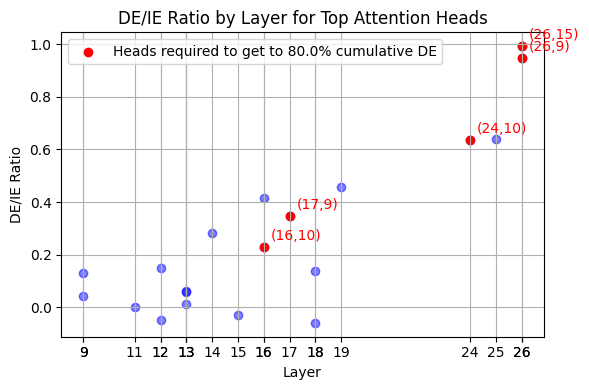

In [16]:
def get_top_act_heads_info():
    path_patch = get_patching_results('path')
    act_patch = get_patching_results('activation')
    
    # Find top 20 indices of act_patch
    flat_indices = np.argsort(act_patch.ravel())[-20:]
    top_layers, top_heads = np.unravel_index(flat_indices, act_patch.shape)
    
    # Calculate ratios at those indices
    ratios = path_patch.ravel()[flat_indices] / act_patch.ravel()[flat_indices]
    
    # Sort everything by activation patch values in descending order
    act_values = act_patch.ravel()[flat_indices]
    sorted_indices = np.argsort(act_values)[::-1]
    act_values = act_values[sorted_indices]
    path_values = path_patch.ravel()[flat_indices][sorted_indices]
    ratios = ratios[sorted_indices]
    top_layers = top_layers[sorted_indices]
    top_heads = top_heads[sorted_indices]
    
    # Convert to list of (layer, head) tuples
    top_heads_tuples = list(zip(top_layers, top_heads))
    
    # # Print results
    # print("\nTop 20 activation patch values and their direct/indirect ratios:")
    # print("Layer | Head | Act Patch | Path Patch | DE/IE Ratio")
    # print("-" * 55)
    # for l, h, act_val, path_val, ratio in zip(top_layers, top_heads, act_values, path_values, ratios):
    #     print(f"{l:5d} | {h:4d} | {act_val:9.3f} | {path_val:9.3f} | {ratio:10.3f}")
    return act_values, path_values, top_heads_tuples

def identify_top_de_heads(threshold = 0.8):
    act_values, path_values, top_heads_tuples = get_top_act_heads_info()
    
    # Sort by path values
    sorted_indices = np.argsort(path_values)[::-1]
    path_values = path_values[sorted_indices]
    top_heads_tuples = [top_heads_tuples[i] for i in sorted_indices]
    
    # Calculate cumulative sum of path patch values
    total_path_effect = np.sum(path_values)
    cumsum_path = np.cumsum(path_values)
    # Find number of heads needed for 95% effect
    target_effect = threshold * total_path_effect
    heads_needed = np.searchsorted(cumsum_path, target_effect) + 1
    
    # Get the specific heads that contribute to 95% effect
    key_heads = top_heads_tuples[:heads_needed]
    # print(f"\nNeeds {heads_needed} heads to achieve {threshold*100}% of total path patch effect")
    # print("\nKey heads (layer, head):")
    # for l, h in key_heads:
    #     print(f"Layer {l}, Head {h}")

    return key_heads
    

def plot_de_ie_heads_layers(thresh = 0.8):
    act_values, path_values, top_heads_tuples = get_top_act_heads_info()
    ratio = path_values/act_values
    
    # Extract layers from tuples for x-axis
    layers = [t[0] for t in top_heads_tuples]
    
    plt.figure(figsize=(6, 4))
    key_heads = identify_top_de_heads(thresh)
    # Get indices of key heads in top_heads_tuples to get corresponding ratios
    key_head_indices = [top_heads_tuples.index(head) for head in key_heads]
    key_head_ratios = ratio[key_head_indices]
    scatter = plt.scatter(layers, ratio, color='blue', alpha=0.5)
    
    # Plot key heads in red
    key_scatter = plt.scatter([h[0] for h in key_heads], key_head_ratios, color='red', label = f'Heads required to get to {100*thresh}% cumulative DE')
    
    plt.xlabel('Layer')
    plt.ylabel('DE/IE Ratio') 
    plt.title('DE/IE Ratio by Layer for Top Attention Heads')
    plt.grid(True)
    
    # Add layer numbers on x-axis
    plt.xticks(layers)
    
    # Only annotate key heads
    for i, (layer, head) in enumerate(top_heads_tuples):
        if (layer, head) in key_heads:
            plt.annotate(f'({layer},{head})',
                        (layer, ratio[i]),
                        xytext=(5, 5),
                        textcoords='offset points',
                        color='red')
    
    plt.tight_layout()
    plt.legend()
    plt.savefig('figs_addition/ab_attn_heads/de_ie_ratio_key_heads.png')
    plt.show()

plot_de_ie_heads_layers()

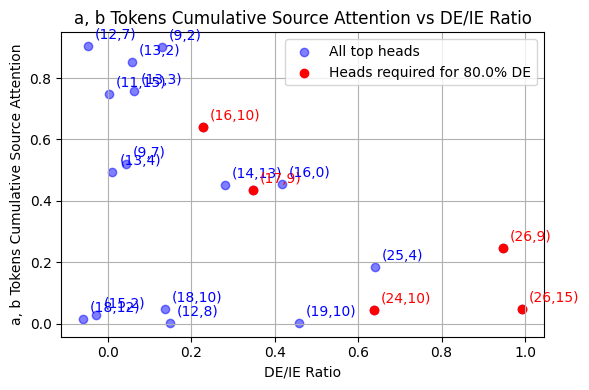

In [41]:
def plot_de_heads_attn(thresh = 0.8):
    act_values, path_values, top_heads_tuples = get_top_act_heads_info()
    attns = get_last_token_attn(top_heads_tuples)
    last_tok_attn = attns[:,-1]
    ratio = path_values/act_values
    
    # Extract layers from tuples for x-axis
    layers = [t[0] for t in top_heads_tuples]
    
    plt.figure(figsize=(6, 4))
    key_heads = identify_top_de_heads(thresh)
    key_head_last_tok = get_last_token_attn(key_heads)[:,-1]
    # Get indices of key heads in top_heads_tuples to get corresponding ratios
    key_head_indices = [top_heads_tuples.index(head) for head in key_heads]
    key_head_ratios = ratio[key_head_indices]
    scatter = plt.scatter(ratio, last_tok_attn, color='blue', alpha=0.5, label='All top heads')
    # Plot key heads in red
    key_scatter = plt.scatter(key_head_ratios, key_head_last_tok, color='red', label=f'Heads required for {100*thresh}% DE')
    
    # Annotate all points
    for i, (layer, head) in enumerate(top_heads_tuples):
        plt.annotate(f'({layer},{head})',
                    (ratio[i], last_tok_attn[i]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color='blue' if (layer, head) not in key_heads else 'red')
    
    plt.xlabel('DE/IE Ratio')
    plt.ylabel('Last Token Source Attention')
    plt.title('Last Token Source Attention vs DE/IE Ratio for Top Attention Heads')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs_addition/ab_attn_heads/last_tok_attn_de_ie_heads.png')


def plot_ie_heads_attn(thresh = 0.8):
    act_values, path_values, top_heads_tuples = get_top_act_heads_info()
    attns = get_last_token_attn(top_heads_tuples)
    last_tok_attn = attns[:,-2] + attns[:,-4]
    ratio = path_values/act_values
    
    # Extract layers from tuples for x-axis
    layers = [t[0] for t in top_heads_tuples]
    
    plt.figure(figsize=(6, 4))
    key_heads = identify_top_de_heads(thresh)
    key_head_last_tok = get_last_token_attn(key_heads)
    key_head_last_tok = key_head_last_tok[:,-2]+key_head_last_tok[:,-4]
    # Get indices of key heads in top_heads_tuples to get corresponding ratios
    key_head_indices = [top_heads_tuples.index(head) for head in key_heads]
    key_head_ratios = ratio[key_head_indices]
    scatter = plt.scatter(ratio, last_tok_attn, color='blue', alpha=0.5, label='All top heads')
    # Plot key heads in red
    key_scatter = plt.scatter(key_head_ratios, key_head_last_tok, color='red', label=f'Heads required for {100*thresh}% DE')
    
    # Annotate all points
    for i, (layer, head) in enumerate(top_heads_tuples):
        plt.annotate(f'({layer},{head})',
                    (ratio[i], last_tok_attn[i]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    color='blue' if (layer, head) not in key_heads else 'red')
    
    plt.xlabel('DE/IE Ratio')
    plt.ylabel('a, b Tokens Cumulative Source Attention')
    plt.title('a, b Tokens Cumulative Source Attention vs DE/IE Ratio')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs_addition/ab_attn_heads/a_b_tok_attn_de_ie_heads.png')

plot_ie_heads_attn()